/mnt/Research
ab_hint dim: torch.Size([2, 288, 448])
ab_mask dim: torch.Size([1, 288, 448])


<IPython.core.display.Javascript object>


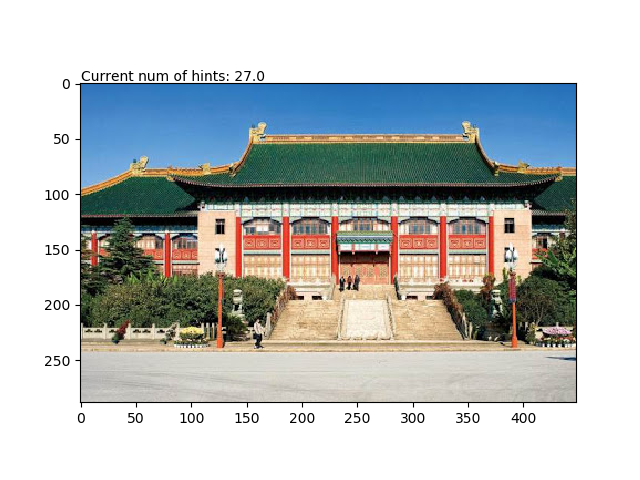

In [12]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from skimage import io, color
import torch

frames = torch.randint(low=1, high=5000, size=[2])
%cd /mnt/Research
# original = io.imread(f'datasets/train/qing-ep17-{frames[0]:05d}.png')[:320, :320]
# original = io.imread(f'nature.jpg')[:640, :640]
original = io.imread(f'ShanghaiProject/city-hall.jpg')[:288, :448]
lab = torch.tensor(color.rgb2lab(original)).float()

permuted_lab = lab.permute(2, 0, 1)
L_channel = permuted_lab[[0]]
ab_channel = permuted_lab[1:]
ab_hint = torch.zeros_like(ab_channel)
ab_mask = torch.zeros_like(L_channel)
print(f'ab_hint dim: {ab_hint.shape}')
print(f'ab_mask dim: {ab_mask.shape}')


fig, ax = plt.subplots()
ax.imshow(original)
text = ax.text(0,0, "", va="bottom", ha="left")
text.set_text(f'Current num of hints: {ab_mask.nonzero().sum()}')

# fig2, ax2 = plt.subplots()
# fig3, ax3 = plt.subplots()

def onclick(event):
    x = int(event.xdata)
    y = int(event.ydata)
    print(f'({x}, {y}): {original[y, x]}')
    ab_mask[0, y, x] = 1
    ab_hint[:, y, x] = ab_channel[:, y, x]
    text.set_text(f'Current num of hints: {ab_mask.sum()}')
    
    stacked_ab_mask = torch.cat((ab_mask, ab_mask), dim=0)
    L_hint = torch.ones_like(L_channel) * 50
    replaced_ab_channels = torch.where(stacked_ab_mask > 0, ab_hint, ab_channel)
    replaced_L_channel = torch.where(ab_mask > 0, L_hint, L_channel)
    replaced_batch = torch.cat((replaced_L_channel, replaced_ab_channels), dim=0)
    replaced_batch = replaced_batch.permute(1, 2, 0).cpu().numpy()
    replaced_img1 = color.lab2rgb(replaced_batch)
    
#     ax2.imshow(ab_mask[0].cpu().numpy())
#     ax3.imshow(replaced_img1)

# Create an hard reference to the callback not to be cleared by the garbage collector
ka = fig.canvas.mpl_connect('button_press_event', onclick)


def decode_ind_ab(data_q):
    # Decode index into ab value
    # INPUTS
    #   data_q      Nx1xHxW \in [0,Q)
    # OUTPUTS
    #   data_ab     Nx2xHxW \in [-1,1]

    ab_max = 110
    ab_quant = 10
    A = 2 * ab_max / ab_quant + 1

    data_a = data_q / A
    data_b = data_q - data_a * A
    data_ab = torch.cat((data_a, data_b), dim=1)
    data_ab = ((data_ab.float() * ab_quant) - 110) / 110

    return data_ab


def decode_max_ab(data_ab_quant):
    # Decode probability distribution by using bin with highest probability
    # INPUTS
    #   data_ab_quant   NxQxHxW \in [0,1]
    # OUTPUTS
    #   data_ab         Nx2xHxW \in [-1,1]

    data_q = torch.argmax(data_ab_quant,dim=1)[:,None,:,:]
    return decode_ind_ab(data_q)


def decode_mean(data_ab_quant):
    # Decode probability distribution by taking mean over all bins
    # INPUTS
    #   data_ab_quant   NxQxHxW \in [0,1]
    # OUTPUTS
    #   data_ab_inf     Nx2xHxW \in [-1,1]

    (N,Q,H,W) = data_ab_quant.shape
    ab_max = 110
    ab_quant = 10
    ab_norm = 110
    A = 2 * ab_max / ab_quant + 1
    a_range = torch.range(-ab_max, ab_max, step=ab_quant).to(data_ab_quant.device)[None,:,None,None]
    a_range = a_range.type(data_ab_quant.type())

    # reshape to AB space
    data_ab_quant = data_ab_quant.view((N, int(A), int(A), H, W))
    data_a_total = torch.sum(data_ab_quant,dim=2)
    data_b_total = torch.sum(data_ab_quant,dim=1)

    # matrix multiply
    data_a_inf = torch.sum(data_a_total * a_range,dim=1,keepdim=True)
    data_b_inf = torch.sum(data_b_total * a_range,dim=1,keepdim=True)

    data_ab_inf = torch.cat((data_a_inf,data_b_inf),dim=1) / ab_norm

    return data_ab_inf

In [13]:
%cd /mnt/Research/ShanghaiProject/code
from model.zhang_model import SIGGRAPHGenerator
from torchvision import transforms

model = SIGGRAPHGenerator(4, 2)
state_dict = torch.load('checkpoint/siggraph_caffemodel/latest_net_G.pth', map_location=torch.device('cuda'))
model.load_state_dict(state_dict)

input_L = ((L_channel - 50) / 100).unsqueeze(0)
input_ab = (ab_hint / 110).unsqueeze(0)
input_mask = ab_mask.unsqueeze(0)  # torch.ones_like(ab_mask.unsqueeze(0))

print(input_L.max())
print(input_L.min())
print(input_ab[:, 0].max())
print(input_ab[:, 0].min())
print(input_ab[:, 1].max())
print(input_ab[:, 1].min())

print(f'normalized_L shape: {input_L.shape}, ab: {input_ab.shape}, {input_mask.shape}')

print(f'Num hints: {input_mask.sum()}')

out_class, out_reg = model(input_L, input_ab, input_mask)

fake_B_dec_max = model.upsample4(decode_max_ab(out_class))
fake_B_distr = model.softmax(out_class)
fake_B_dec_mean = model.upsample4(decode_mean(fake_B_distr))

/mnt/Research/ShanghaiProject/code
tensor(0.5000)
tensor(-0.5000)
tensor(0.5811)
tensor(-0.2213)
tensor(0.4718)
tensor(-0.3966)
normalized_L shape: torch.Size([1, 1, 288, 448]), ab: torch.Size([1, 2, 288, 448]), torch.Size([1, 1, 288, 448])
Num hints: 27.0


<ipython-input-12-386bdad46156>:97: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  a_range = torch.range(-ab_max, ab_max, step=ab_quant).to(data_ab_quant.device)[None,:,None,None]


torch.Size([1, 529, 72, 112])
torch.Size([1, 2, 288, 448])
tensor(100., grad_fn=<MaxBackward1>)
tensor(0., grad_fn=<MinBackward1>)
tensor(80.9516, grad_fn=<MaxBackward1>)
tensor(-30.9652, grad_fn=<MinBackward1>)
tensor(57.5751, grad_fn=<MaxBackward1>)
tensor(-95.4225, grad_fn=<MinBackward1>)
(288, 448, 3)


<IPython.core.display.Javascript object>


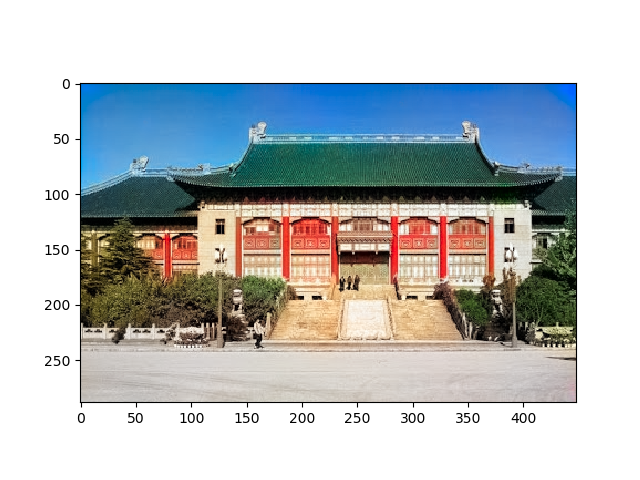

In [14]:
print(out_class.shape)
print(out_reg.shape)

generated_image = torch.cat((L_channel, out_reg[0] * 110), dim=0)
print(generated_image[0].max())
print(generated_image[0].min())
print(generated_image[1].max())
print(generated_image[1].min())
print(generated_image[2].max())
print(generated_image[2].min())

generated_image = generated_image.permute(1, 2, 0).detach().numpy()

print(generated_image.shape)

plt.figure()
plt.imshow(color.lab2rgb(generated_image))

In [4]:
plt.imshow(color.lab2rgb(torch.cat((L_channel, ab_channel), dim=0).permute(1, 2, 0).numpy()))

In [6]:
print((out_reg[0] * 110).max())
print((out_reg[0] * 110).min())

tensor(79.4585, grad_fn=<MaxBackward1>)
tensor(-79.2566, grad_fn=<MinBackward1>)
